<a href="https://colab.research.google.com/github/keeley1/mnist-model/blob/main/mnist_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Model Report


## Universal Workflow
This report will follow the universal workflow for machine learning, which is as follows:

*   Defining the problem, assembling a dataset
*   Choose measure of success
*   Decide on evaluation protocol
*   Prepare data
*   Develop model that performs better than baseline
*   Develop a model that overfits
*   Regularise model, tune hyperparameters based on performance on validation data










#Introduction

## Assembling a dataset / Introduction to MNIST

The MNIST dataset is a collection of 60,000 training and 10,000 testing images and labels. The MNIST images are sized 28x28 and are greyscale and consist of handwritten digits and the correct descriptive label. MNIST has been referred to as the "Hello World" of deep learning due to its simplicity and widespread use in scientific papers. Therefore, MNIST is a perfect starting point for grasping the deep learning methodology.

## Defining the Problem

The problem that this report aims to solve is the classification of the MNIST dataset into their corresponding 10 categories or classes consisting of 0 - 9.

### MNIST Example Data

Lets take a look at some examples of MNIST data for reference.

Before this can be displayed, we must start by importing TensorFlow, NumPy, and Matplotlib:

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Now lets download our dataset from TensorFlow using Keras, a google developed API for implementing neural networks. This works on top of TensorFlow, making it easier to build and train models.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Now that the data is loaded, lets take a look at an example:


label:  9

image: 


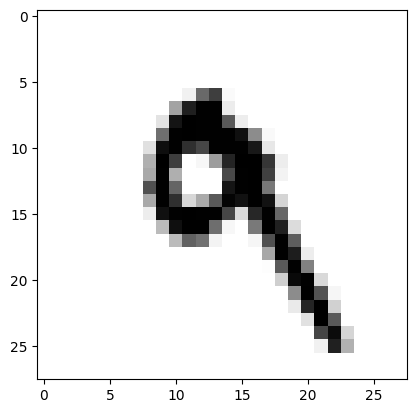

In [ ]:
# sample data from test dataset
print('label: ', test_labels[7])
print()
print('image: ')
plt.imshow(test_images[7], cmap = plt.cm.binary)
plt.show()

We can also create a 4x4 grid of sample data:

In [ ]:
def mnist_peek(rows, cols):
    fig, axs = plt.subplots(rows, cols)
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(train_images[i * cols + j], cmap = plt.cm.binary)

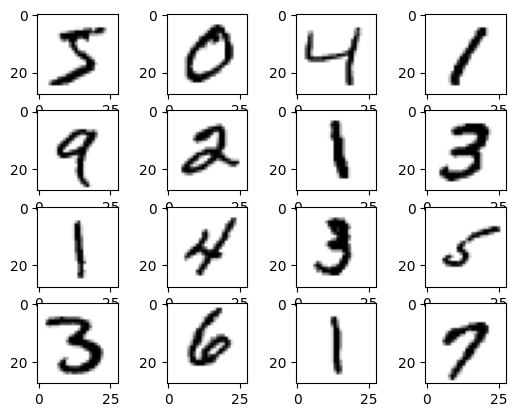

In [ ]:
mnist_peek(4, 4)

## Measure of Success

As there are 10 classes in the dataset, it is expected that the baseline accuracy should be approximately 10%. This report will use accuracy as a measure of success and will attempt to beat this. Minimal loss will also be used.

## Evaluation Protocol

The evaluation protocol chosen is hold-out validation. This envolves the training dataset being split into training and validation sets, with typical ratios being 80-20 and 70-30 (with the smaller being the validation set).

This technique is great for larger datasets such as this, whereas techniques like K-fold validation, where the training dataset is split equally, are typically used with smaller sets of data.



## Preparing Data

Lets first take a look at the tensor shapes of the data as loaded:

In [ ]:
print("tensor:\t\t shape")
print("-"*22)
print("training images:", train_images.shape)
print("training labels:", train_labels.shape)
print("test images:\t", test_images.shape)
print("test labels:\t", test_labels.shape)

tensor:		 shape
----------------------
training images: (60000, 28, 28)
training labels: (60000,)
test images:	 (10000, 28, 28)
test labels:	 (10000,)


Preprocessing the data is an important step in ensuring that all of the data is in an acceptable form for the network.

In this instance, the images will be flattened into 1 dimensional arrays of size 28x28. The pixel values are normalised to sit as floats between 0 and 1 as neural networks are known to perform better with normalised data.

In [ ]:
# save raw test data for future reference
raw_test_images, raw_test_labels = test_images, test_labels

# convert to 28x28 arrays
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

# normalise pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In addition to preprocessing the images, the labels are also modified to comply with the specifications of the model.

In this instance, the chosen activation function for the output layer is softmax. It is a commonly suggested choice for tasks like multi-class classification, as in this project. Softmax converts the output scores into probability distributions across the various classes. Therefore, using one-hot encoding for the labels is logical as it transforms each label into a 10-element vector with a singular "hot" non-zero entry.

In [ ]:
from tensorflow.keras.utils import to_categorical

orig_label   = test_labels[8]

# set labels to categorical
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

# check encoding
print(f"'{orig_label}' as a one-hot vector: {test_labels[8]}")

'5' as a one-hot vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Methodology

## Baseline Model

Now that the data has been preprocessed, we can find the baseline using a simple model.

This model has two layers, one with 512 neurons and one with 10, matching the number of classes.

The chosen activations for this model are ReLU and softmax. ReLU replaces negative output values with zero, allowing the network to model more complex relationships. It is also known to be computationally efficient.

Softmax is a common output layer choice for multi-class classifcation problems such as this. Each neuron in the output layer corresponds to one class, where the probability distribution is calculated.

The compilation consists of:
*   **Loss function:** how the network is able to measure its performance on training data, guiding optimisation
*   **Optimiser:** mechanism for network to update itself during training, based on data seen and the loss function
*   **Metrics:** what we are monitoring during training and testing such as accuracy







The loss function, categorical_crossentropy, is commonly used in situations where the goal is to assign probability distribution across multiple classes. The optimiser is rmsprop, often used with larger datasets, and the metrics for this model are accuracy.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

Once the model has been built, the baseline accuracy can be tested:

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Model accuracy: {test_accuracy}")
print(f"Loss: {test_loss}")

313/313 [==============================] - 1s 2ms/step - loss: 2.3513 - accuracy: 0.1221
Model accuracy: 0.12210000306367874
Loss: 2.3513400554656982


The model accuracy is approximately 11%, which is about what was hypothesised the baseline model would be, based on the 10 possible classes.

## Model One
"A model that does better than the baseline"

The goal of this model is to perform better than the baseline, this means the accuracy of the model should be above 11%. This model has the same hyperparameters as the baseline and will be trained for 5 epochs with a batch size of 128.

In [ ]:
# lets train the model
model_one = tf.keras.models.Sequential()
model_one.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
model_one.add(tf.keras.layers.Dense(10, activation='softmax'))

model_one.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_one_history = model_one.fit(train_images, train_labels, epochs = 5, batch_size = 128)

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3387 - accuracy: 0.9064
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1660 - accuracy: 0.9521
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1190 - accuracy: 0.9656
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0917 - accuracy: 0.9731
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.9786


In [ ]:
test_loss, test_accuracy = model_one.evaluate(test_images, test_labels)

print(f"Model accuracy: {test_accuracy}")
print(f"Loss: {test_loss}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0880 - accuracy: 0.9743
Model accuracy: 0.9743000268936157
Loss: 0.08801750838756561


After training, the accuracy for model one is 97%. This means the model has successfully beat the baseline.

Now we can take a look at some example predictions using the test data:

In [ ]:
def predict_and_print(model, test_image, test_image_label):
    preds = model.predict(test_images[test_image:test_image + 1], verbose=0)
    argmax_class = np.argmax(preds[0])

    # Save highest probability
    highest_prob_class = argmax_class

    # Print probabilities
    for i, probability in enumerate(preds[0]):
        if i == argmax_class:
            print(f"\033[1mClass: {i:2} with Probability: {probability:.15f}\033[0m (Highest Probability)")
        else:
            print(f"Class: {i:2} with Probability: {probability:.15f}")

    print(f"\nPredicted class: {highest_prob_class}")
    print(f"Actual class: {raw_test_labels[test_image_label]}")

predict_and_print(model_one, 0, 0)

Class:  0 with Probability: 0.000000869760242
Class:  1 with Probability: 0.000000056585019
Class:  2 with Probability: 0.000065336469561
Class:  3 with Probability: 0.000383184844395
Class:  4 with Probability: 0.000000004254575
Class:  5 with Probability: 0.000000352001933
Class:  6 with Probability: 0.000000000003861
Class:  7 with Probability: 0.999534130096436 (Highest Probability)
Class:  8 with Probability: 0.000001886787231
Class:  9 with Probability: 0.000014208376342

Predicted class: 7
Actual class: 7


In [ ]:
predict_and_print(model_one, 1, 1)

Class:  0 with Probability: 0.000000506374931
Class:  1 with Probability: 0.000180460352567
Class:  2 with Probability: 0.998506128787994 (Highest Probability)
Class:  3 with Probability: 0.000919152633287
Class:  4 with Probability: 0.000000000014574
Class:  5 with Probability: 0.000378807686502
Class:  6 with Probability: 0.000005316309853
Class:  7 with Probability: 0.000000000011149
Class:  8 with Probability: 0.000009679933100
Class:  9 with Probability: 0.000000001516308

Predicted class: 2
Actual class: 2


We can also plot the training loss and accuracy from the first model:

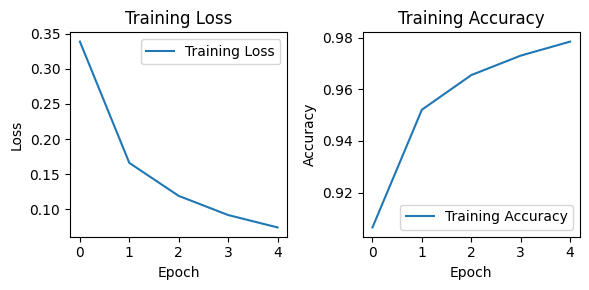

In [ ]:
# plot training loss
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(model_one_history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model_one_history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Validation

As discussed under evaluation protocol, this report will use hold-out evaluation. This method involves dividing the training data into two subsets: a validation set, comprising the initial 10,000 images and labels, and the remaining portion of the training set, which can be referred to as the partial training dataset.

In [ ]:
# contains remaining images and labels as partial training dataset
partial_image_train = train_images[10000:]
partial_label_train = train_labels[10000:]

# first 10,000 images and labels as validation dataset
image_val = train_images[:10000]
label_val = train_labels[:10000]

## Model Two - Validation

The second model will train with the partial dataset and test using the validation set. For this model, the hyperparameters are the same as model one.

In [ ]:
# model two:
model_two = tf.keras.models.Sequential()
model_two.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
model_two.add(tf.keras.layers.Dense(10, activation='softmax'))

model_two.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

# train with partial training set
model_two_history = model_two.fit(partial_image_train, partial_label_train, epochs = 5, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/5
391/391 [==============================] - 2s 3ms/step - loss: 0.3656 - accuracy: 0.8988 - val_loss: 0.2194 - val_accuracy: 0.9384
Epoch 2/5
391/391 [==============================] - 1s 3ms/step - loss: 0.1794 - accuracy: 0.9492 - val_loss: 0.1625 - val_accuracy: 0.9543
Epoch 3/5
391/391 [==============================] - 1s 3ms/step - loss: 0.1311 - accuracy: 0.9626 - val_loss: 0.1346 - val_accuracy: 0.9605
Epoch 4/5
391/391 [==============================] - 1s 3ms/step - loss: 0.1020 - accuracy: 0.9702 - val_loss: 0.1103 - val_accuracy: 0.9676
Epoch 5/5
391/391 [==============================] - 1s 3ms/step - loss: 0.0829 - accuracy: 0.9760 - val_loss: 0.1000 - val_accuracy: 0.9705


Now we can plot the training loss/accuracy against the validation loss/accuracy:

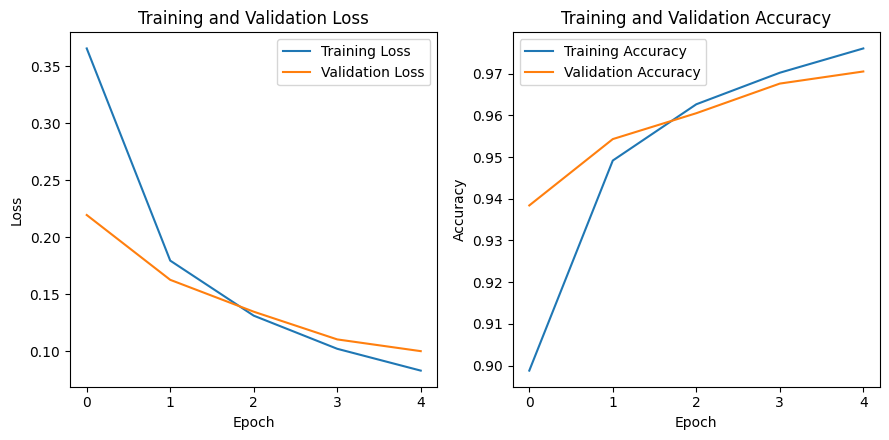

In [ ]:
plt.figure(figsize=(9, 4.5))

# plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model_two_history.history['loss'], label='Training Loss')
plt.plot(model_two_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model_two_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_two_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

We can also check the accuracy of the new model:

In [ ]:
test_loss, test_accuracy = model_two.evaluate(test_images, test_labels)

print(f"Model accuracy: {test_accuracy}")
print(f"Loss: {test_loss}")

313/313 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9717
Model accuracy: 0.9717000126838684
Loss: 0.09546905755996704


The second model also has an accuracy of 97%.

Based on the performance metrics of model two, it does not appear to be overfitting. The training and validation loss is decreasing while the accuracy is increasing. These values also stay relatively close to one another.

We can also test a model prediction:

In [ ]:
predict_and_print(model_two, 9, 9)

Class:  0 with Probability: 0.000000130356980
Class:  1 with Probability: 0.000000000047916
Class:  2 with Probability: 0.000000067373513
Class:  3 with Probability: 0.000028936188755
Class:  4 with Probability: 0.005108062643558
Class:  5 with Probability: 0.000000131528310
Class:  6 with Probability: 0.000000000542168
Class:  7 with Probability: 0.000585755042266
Class:  8 with Probability: 0.001081915223040
Class:  9 with Probability: 0.993194937705994 (Highest Probability)

Predicted class: 9
Actual class: 9


Moving forward, these functions will help for faster model evaluation:

In [ ]:
def plot_training_history(history, figsize = (9, 4.5)):
    plt.figure(figsize = figsize)

    # plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    min_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
    plt.axvline(x = min_val_loss_epoch, color = 'r', linestyle = '--', label = f'Min Loss Epoch: {min_val_loss_epoch}')
    plt.legend()

    # plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label = 'Training Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    max_val_acc_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    plt.axvline(x = max_val_acc_epoch, color = 'r', linestyle = '--', label = f'Max Acc Epoch: {max_val_acc_epoch}')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

import pandas as pd
from IPython.display import display

def compare_models(models, model_names, test_data, test_labels):

    results = []
    for model, name in zip(models, model_names):
        test_loss, test_accuracy = model.evaluate(test_data, test_labels)
        results.append({
            'Model': name,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy
        })

    df = pd.DataFrame(results)

    # display and return dataframe
    display(df)
    return df

## Model Three - Increasing Epochs


Start tuning hyperparameters by doubling the epochs to see if an increase in epochs improves the model:

In [ ]:
# model three:
model_three = tf.keras.models.Sequential()
model_three.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
model_three.add(tf.keras.layers.Dense(10, activation='softmax'))

model_three.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_three_history = model_three.fit(partial_image_train, partial_label_train, epochs = 10, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/10
391/391 [==============================] - 1s 3ms/step - loss: 0.3582 - accuracy: 0.9016 - val_loss: 0.2203 - val_accuracy: 0.9373
Epoch 2/10
391/391 [==============================] - 1s 3ms/step - loss: 0.1770 - accuracy: 0.9493 - val_loss: 0.1624 - val_accuracy: 0.9533
Epoch 3/10
391/391 [==============================] - 1s 3ms/step - loss: 0.1275 - accuracy: 0.9633 - val_loss: 0.1402 - val_accuracy: 0.9589
Epoch 4/10
391/391 [==============================] - 1s 3ms/step - loss: 0.0992 - accuracy: 0.9717 - val_loss: 0.1146 - val_accuracy: 0.9662
Epoch 5/10
391/391 [==============================] - 1s 3ms/step - loss: 0.0809 - accuracy: 0.9765 - val_loss: 0.1033 - val_accuracy: 0.9681
Epoch 6/10
391/391 [==============================] - 1s 3ms/step - loss: 0.0676 - accuracy: 0.9806 - val_loss: 0.0957 - val_accuracy: 0.9712
Epoch 7/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0567 - accuracy: 0.9838 - val_loss: 0.0881 - val_accuracy: 0.9740
Epoch 

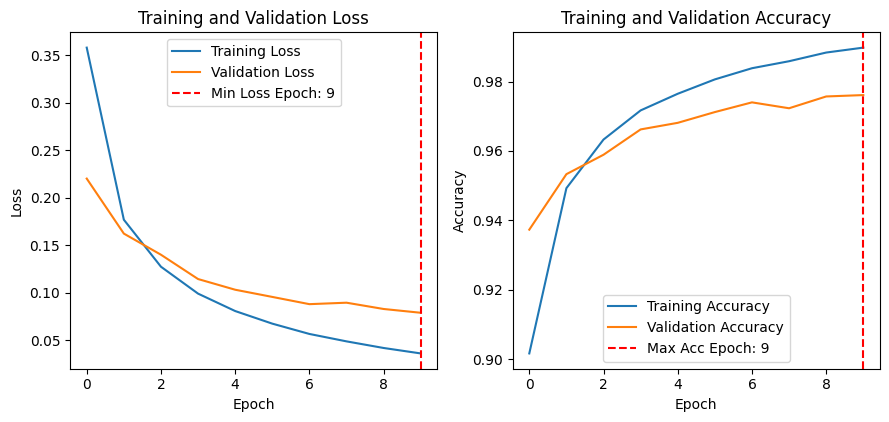

In [ ]:
plot_training_history(model_three_history)

In [ ]:
test_loss, test_accuracy = model_three.evaluate(test_images, test_labels)

print(f"Model accuracy: {test_accuracy}")
print(f"Loss: {test_loss}")

313/313 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9768
Model accuracy: 0.9768000245094299
Loss: 0.07593905925750732


We can also compare the accuracy and loss across models two and three:

In [ ]:
models = [model_two, model_three]
model_names = ['Model Two', 'Model Three']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9768


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768


As seen in the dataframe, doubling the epochs has not resulted in much of an accuracy increase / loss decrease. No overfitting is occurring at this stage. Lets try doubling the epochs again:

## Model Four - Increasing Epochs

Observing doubling epochs to 20:

In [ ]:
# model four:
model_four = tf.keras.models.Sequential()
model_four.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
model_four.add(tf.keras.layers.Dense(10, activation='softmax'))

model_four.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_four_history = model_four.fit(partial_image_train, partial_label_train, epochs = 20, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3677 - accuracy: 0.8990 - val_loss: 0.2222 - val_accuracy: 0.9396
Epoch 2/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1862 - accuracy: 0.9471 - val_loss: 0.1621 - val_accuracy: 0.9537
Epoch 3/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1348 - accuracy: 0.9616 - val_loss: 0.1269 - val_accuracy: 0.9637
Epoch 4/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1051 - accuracy: 0.9701 - val_loss: 0.1151 - val_accuracy: 0.9670
Epoch 5/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0855 - accuracy: 0.9758 - val_loss: 0.1080 - val_accuracy: 0.9672
Epoch 6/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0718 - accuracy: 0.9792 - val_loss: 0.1047 - val_accuracy: 0.9680
Epoch 7/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0606 - accuracy: 0.9825 - val_loss: 0.0928 - val_accuracy: 0.9735
Epoch 

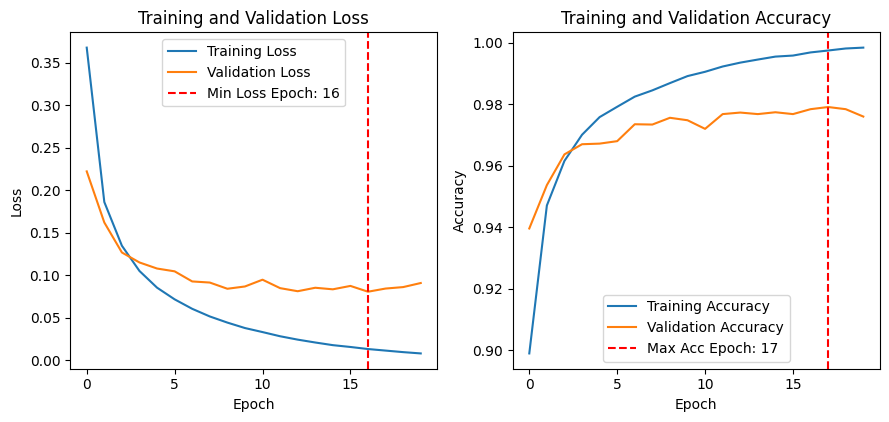

In [ ]:
plot_training_history(model_four_history)

In [ ]:
models = [model_two, model_three, model_four]
model_names = ['Model Two', 'Model Three', 'Model Four']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0842 - accuracy: 0.9776


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776


Model four demonstrates an increase in accuracy overall, and a slight increase in loss. As the increase in epochs has resulted in a more successful model and no sign of overfitting so far, we can explore adding more epochs.

## Model Five - Increasing Epochs

For this model, the number of epochs has been doubled again to 40.

In [ ]:
# model five:
model_five = tf.keras.models.Sequential()
model_five.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
model_five.add(tf.keras.layers.Dense(10, activation='softmax'))

model_five.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_five_history = model_five.fit(partial_image_train, partial_label_train, epochs = 40, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/40
391/391 [==============================] - 3s 6ms/step - loss: 0.3662 - accuracy: 0.8997 - val_loss: 0.2149 - val_accuracy: 0.9377
Epoch 2/40
391/391 [==============================] - 1s 3ms/step - loss: 0.1766 - accuracy: 0.9498 - val_loss: 0.1518 - val_accuracy: 0.9566
Epoch 3/40
391/391 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9631 - val_loss: 0.1239 - val_accuracy: 0.9652
Epoch 4/40
391/391 [==============================] - 1s 3ms/step - loss: 0.0976 - accuracy: 0.9719 - val_loss: 0.1079 - val_accuracy: 0.9687
Epoch 5/40
391/391 [==============================] - 1s 3ms/step - loss: 0.0788 - accuracy: 0.9779 - val_loss: 0.0980 - val_accuracy: 0.9695
Epoch 6/40
391/391 [==============================] - 1s 3ms/step - loss: 0.0659 - accuracy: 0.9804 - val_loss: 0.0908 - val_accuracy: 0.9725
Epoch 7/40
391/391 [==============================] - 1s 3ms/step - loss: 0.0553 - accuracy: 0.9843 - val_loss: 0.0859 - val_accuracy: 0.9749
Epoch 

In [ ]:
models = [model_two, model_three, model_four, model_five]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.1054 - accuracy: 0.9786


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786


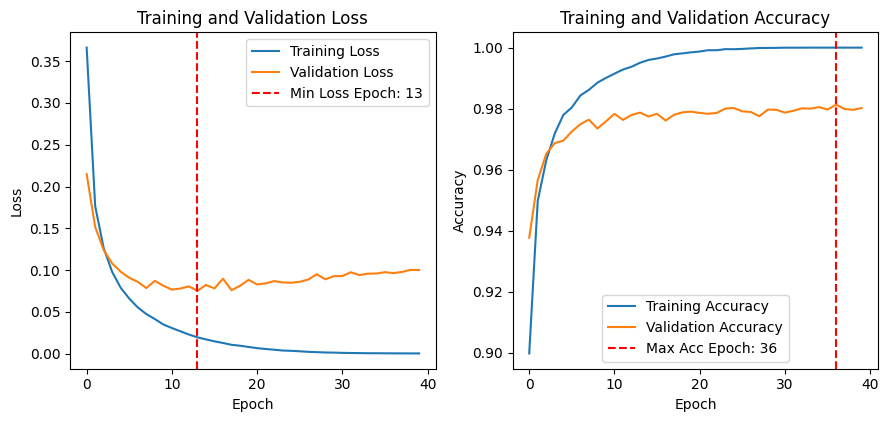

In [ ]:
plot_training_history(model_five_history)

The above charts reveal that the highest accuracy occurs during epoch 26. Consequently, I will proceed with training for 30 epochs as it appears to be the optimal number at this stage.

## Model Six - Adding Layer

The new layer in the model also has a ReLU activation and the number of neurons is 64, half of the first layer.

Observing the effect of an extra model layer:


In [ ]:
# model six:
model_six = tf.keras.models.Sequential()
model_six.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
model_six.add(tf.keras.layers.Dense(64, activation='relu'))
model_six.add(tf.keras.layers.Dense(10, activation='softmax'))

model_six.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_six_history = model_six.fit(partial_image_train, partial_label_train, epochs = 30, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/30
391/391 [==============================] - 2s 3ms/step - loss: 0.3452 - accuracy: 0.9030 - val_loss: 0.2013 - val_accuracy: 0.9416
Epoch 2/30
391/391 [==============================] - 1s 3ms/step - loss: 0.1515 - accuracy: 0.9545 - val_loss: 0.1284 - val_accuracy: 0.9623
Epoch 3/30
391/391 [==============================] - 2s 4ms/step - loss: 0.1047 - accuracy: 0.9684 - val_loss: 0.1078 - val_accuracy: 0.9681
Epoch 4/30
391/391 [==============================] - 2s 4ms/step - loss: 0.0799 - accuracy: 0.9757 - val_loss: 0.0917 - val_accuracy: 0.9730
Epoch 5/30
391/391 [==============================] - 1s 3ms/step - loss: 0.0619 - accuracy: 0.9811 - val_loss: 0.0944 - val_accuracy: 0.9721
Epoch 6/30
391/391 [==============================] - 1s 3ms/step - loss: 0.0505 - accuracy: 0.9843 - val_loss: 0.0903 - val_accuracy: 0.9736
Epoch 7/30
391/391 [==============================] - 1s 3ms/step - loss: 0.0412 - accuracy: 0.9875 - val_loss: 0.0902 - val_accuracy: 0.9756
Epoch 

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9787


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787


Adding a layer to the model has increased the accuracy from 97.8% to 98% however, the loss has also increased from 10% to 12%. This additional layer will also result in a increase in computational cost.

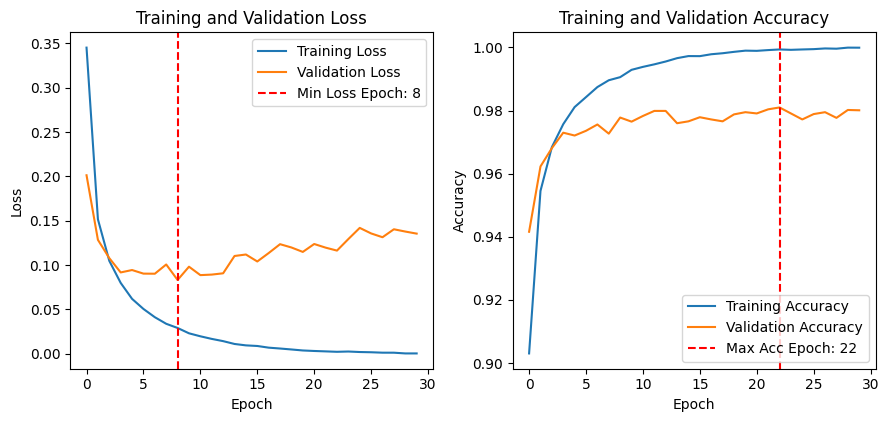

In [ ]:
plot_training_history(model_six_history)

With the loss and accuracy plotted, we can see that the minimum loss epoch has also lowered to 5 in this model however, the maximum accuracy has stayed at 26.

The addition of another layer has not made a noticeable improvement to the performance of the model. Therefore, we can infer that the optimum number of layers for the model is 2.

## Model Seven - Increasing Units

Lets explore if tuning the unit/neuron hyperparameter impacts the model success. In this model, the units have been quadrupled to 512.

In [ ]:
# model seven:
model_seven = tf.keras.models.Sequential()
model_seven.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model_seven.add(tf.keras.layers.Dense(10, activation='softmax'))

model_seven.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_seven_history = model_seven.fit(partial_image_train, partial_label_train, epochs = 30, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/30
391/391 [==============================] - 3s 8ms/step - loss: 0.2842 - accuracy: 0.9184 - val_loss: 0.1577 - val_accuracy: 0.9523
Epoch 2/30
391/391 [==============================] - 2s 6ms/step - loss: 0.1199 - accuracy: 0.9655 - val_loss: 0.1164 - val_accuracy: 0.9646
Epoch 3/30
391/391 [==============================] - 2s 5ms/step - loss: 0.0802 - accuracy: 0.9770 - val_loss: 0.1021 - val_accuracy: 0.9690
Epoch 4/30
391/391 [==============================] - 2s 6ms/step - loss: 0.0575 - accuracy: 0.9822 - val_loss: 0.0824 - val_accuracy: 0.9744
Epoch 5/30
391/391 [==============================] - 2s 6ms/step - loss: 0.0428 - accuracy: 0.9878 - val_loss: 0.0935 - val_accuracy: 0.9710
Epoch 6/30
391/391 [==============================] - 3s 7ms/step - loss: 0.0327 - accuracy: 0.9905 - val_loss: 0.0717 - val_accuracy: 0.9792
Epoch 7/30
391/391 [==============================] - 3s 7ms/step - loss: 0.0240 - accuracy: 0.9932 - val_loss: 0.0666 - val_accuracy: 0.9810
Epoch 

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0795 - accuracy: 0.9822


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822


Increasing the neurons to 512 has lowered the loss to 7%, the lowest so far. The accuracy has increased but not significantly. Note that there is also no sign of under or overfitting.

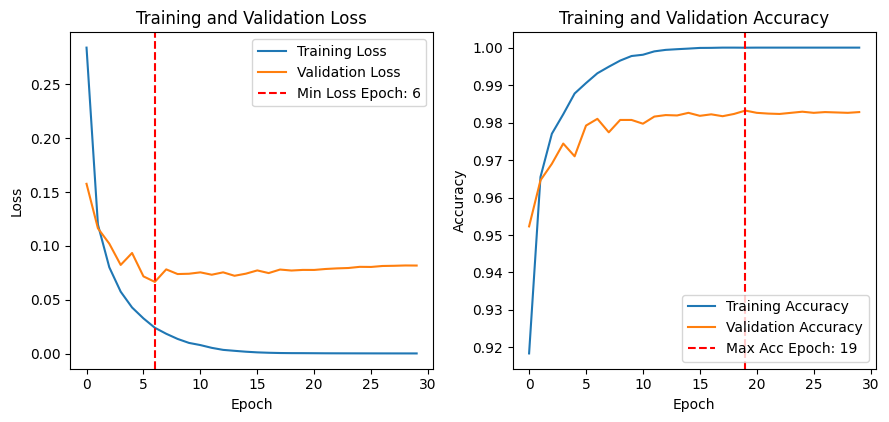

In [ ]:
plot_training_history(model_seven_history)

As increasing the number of neurons appears to decrease the loss and increase the accuracy, lets try increasing the neurons more:

## Model Eight - Increasing Units

For this model, the the units/neurons have been doubled to 1024.

In [ ]:
# model eight:
model_eight = tf.keras.models.Sequential()
model_eight.add(tf.keras.layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))
model_eight.add(tf.keras.layers.Dense(10, activation='softmax'))

model_eight.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_eight_history = model_eight.fit(partial_image_train, partial_label_train, epochs = 30, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/30
391/391 [==============================] - 5s 12ms/step - loss: 0.2621 - accuracy: 0.9229 - val_loss: 0.1826 - val_accuracy: 0.9407
Epoch 2/30
391/391 [==============================] - 4s 11ms/step - loss: 0.1018 - accuracy: 0.9694 - val_loss: 0.0968 - val_accuracy: 0.9706
Epoch 3/30
391/391 [==============================] - 4s 10ms/step - loss: 0.0657 - accuracy: 0.9793 - val_loss: 0.0860 - val_accuracy: 0.9748
Epoch 4/30
391/391 [==============================] - 5s 12ms/step - loss: 0.0462 - accuracy: 0.9860 - val_loss: 0.0805 - val_accuracy: 0.9754
Epoch 5/30
391/391 [==============================] - 4s 11ms/step - loss: 0.0322 - accuracy: 0.9902 - val_loss: 0.0658 - val_accuracy: 0.9800
Epoch 6/30
391/391 [==============================] - 4s 11ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.0766 - val_accuracy: 0.9789
Epoch 7/30
391/391 [==============================] - 5s 13ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0767 - val_accuracy: 0.9802

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven, model_eight]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven', 'Model Eight']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0728 - accuracy: 0.9837


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822
6,Model Eight,0.072769,0.9837


Doubling the neurons has resulted in a further loss decrease and slight accuracy increase. Again, no sign of overfitting at this point.

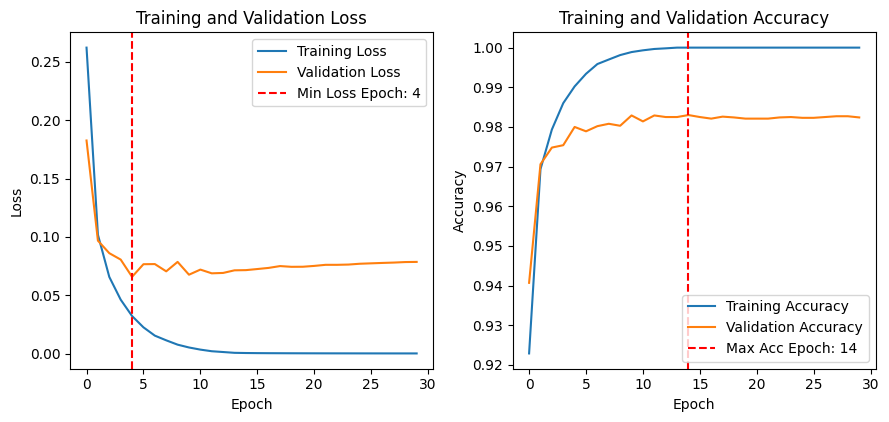

In [ ]:
plot_training_history(model_eight_history)

Interestingly, the increase to 1024 neurons in the first layer has resulted in a lower maximum accuracy epoch of 16.

The loss and accuracy are still decreasing and increasing as expected. Moving forward, I will be adjusting the epochs down to 20.

## Model Nine - Decreasing Epochs

In [ ]:
# model nine:
model_nine = tf.keras.models.Sequential()
model_nine.add(tf.keras.layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))
model_nine.add(tf.keras.layers.Dense(10, activation='softmax'))

model_nine.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_nine_history = model_nine.fit(partial_image_train, partial_label_train, epochs = 20, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/20
391/391 [==============================] - 5s 11ms/step - loss: 0.2664 - accuracy: 0.9210 - val_loss: 0.1384 - val_accuracy: 0.9581
Epoch 2/20
391/391 [==============================] - 5s 13ms/step - loss: 0.1031 - accuracy: 0.9690 - val_loss: 0.0881 - val_accuracy: 0.9734
Epoch 3/20
391/391 [==============================] - 4s 11ms/step - loss: 0.0662 - accuracy: 0.9798 - val_loss: 0.0925 - val_accuracy: 0.9723
Epoch 4/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.0717 - val_accuracy: 0.9788
Epoch 5/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0324 - accuracy: 0.9899 - val_loss: 0.0687 - val_accuracy: 0.9806
Epoch 6/20
391/391 [==============================] - 4s 10ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0845 - val_accuracy: 0.9739
Epoch 7/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0165 - accuracy: 0.9957 - val_loss: 0.0677 - val_accuracy: 0.9817

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven, model_eight, model_nine]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven', 'Model Eight', 'Model Nine']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9840


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822
6,Model Eight,0.072769,0.9837
7,Model Nine,0.070567,0.9840


As seen above, the loss has further decreased to 6.8%, with the accuracy staying at 98% as with the previous model. For now, 20 epochs seems to be the optimum number.

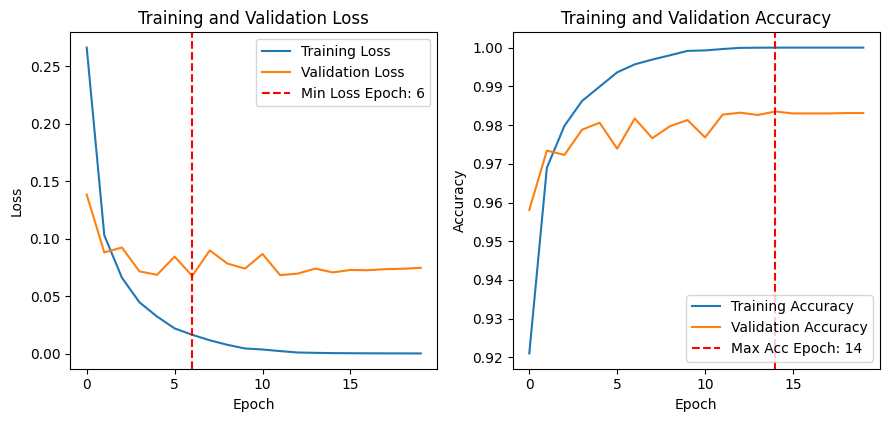

In [ ]:
plot_training_history(model_nine_history)

## Model Ten - Dropout

Dropout is a regularisation technique. It involves regularly "dropping out"/setting to zero a portion of input neurons at updates during training. It is particularly useful in preventing overfitting.

Lets explore dropout, starting with a rate of 0.5.

In [ ]:
from tensorflow.keras.layers import Dropout

# model ten:
model_ten = tf.keras.models.Sequential()
model_ten.add(tf.keras.layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))
model.add(Dropout(0.5))
model_ten.add(tf.keras.layers.Dense(10, activation='softmax'))

model_ten.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_ten_history = model_ten.fit(partial_image_train, partial_label_train, epochs = 20, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/20
391/391 [==============================] - 4s 11ms/step - loss: 0.2659 - accuracy: 0.9216 - val_loss: 0.1487 - val_accuracy: 0.9536
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 0.1028 - accuracy: 0.9695 - val_loss: 0.1142 - val_accuracy: 0.9644
Epoch 3/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0661 - accuracy: 0.9804 - val_loss: 0.0767 - val_accuracy: 0.9765
Epoch 4/20
391/391 [==============================] - 4s 10ms/step - loss: 0.0452 - accuracy: 0.9860 - val_loss: 0.0769 - val_accuracy: 0.9761
Epoch 5/20
391/391 [==============================] - 4s 11ms/step - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.0770 - val_accuracy: 0.9791
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.0700 - val_accuracy: 0.9805
Epoch 7/20
391/391 [==============================] - 4s 10ms/step - loss: 0.0154 - accuracy: 0.9960 - val_loss: 0.0690 - val_accuracy: 0.9820

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven, model_eight, model_nine, model_ten]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven', 'Model Eight', 'Model Nine', 'Model Ten']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0701 - accuracy: 0.9828


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822
6,Model Eight,0.072769,0.9837
7,Model Nine,0.070567,0.9840
8,Model Ten,0.070123,0.9828


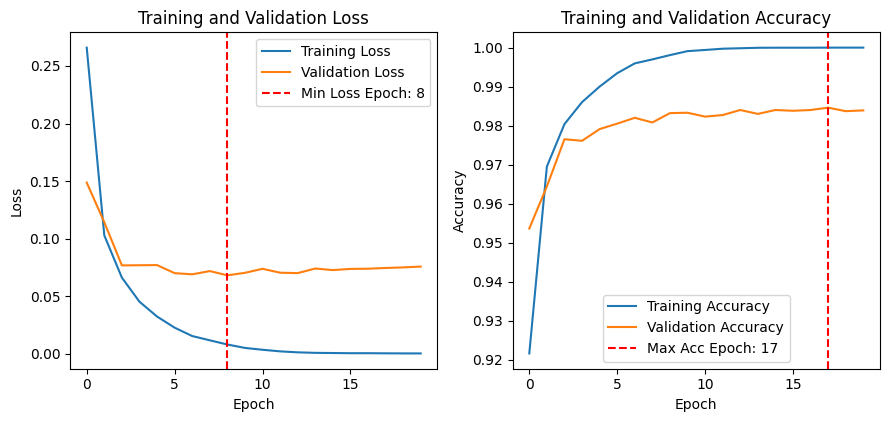

In [ ]:
plot_training_history(model_ten_history)

As demonstrated in the plots and table, adding a dropout has had minimal effect on the loss or accuracy of the model. Therefore, this will not be included in future models.

## Model Eleven - Learning Rate

In neural networks, the learning rate controls the size of steps taken during the optimisation process. The default learning rate for rmsprop is 0.001 so we can start by testing the learning rate of 0.01.

In [ ]:
# model eleven:
model_eleven = tf.keras.models.Sequential()
model_eleven.add(tf.keras.layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))
model_eleven.add(tf.keras.layers.Dense(10, activation='softmax'))

custom_optimiser = tf.keras.optimizers.RMSprop(learning_rate = 0.01)

model_eleven.compile(
    loss='categorical_crossentropy',
    optimizer=custom_optimiser,
    metrics=['accuracy']
)

model_eleven_history = model_eleven.fit(partial_image_train, partial_label_train, epochs = 20, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/20
391/391 [==============================] - 4s 11ms/step - loss: 0.4053 - accuracy: 0.9129 - val_loss: 0.1657 - val_accuracy: 0.9536
Epoch 2/20
391/391 [==============================] - 4s 11ms/step - loss: 0.1283 - accuracy: 0.9647 - val_loss: 0.1813 - val_accuracy: 0.9560
Epoch 3/20
391/391 [==============================] - 4s 11ms/step - loss: 0.1076 - accuracy: 0.9718 - val_loss: 0.1323 - val_accuracy: 0.9717
Epoch 4/20
391/391 [==============================] - 4s 10ms/step - loss: 0.0814 - accuracy: 0.9791 - val_loss: 0.2244 - val_accuracy: 0.9583
Epoch 5/20
391/391 [==============================] - 4s 11ms/step - loss: 0.0760 - accuracy: 0.9821 - val_loss: 0.1771 - val_accuracy: 0.9704
Epoch 6/20
391/391 [==============================] - 4s 11ms/step - loss: 0.0663 - accuracy: 0.9841 - val_loss: 0.2077 - val_accuracy: 0.9695
Epoch 7/20
391/391 [==============================] - 4s 10ms/step - loss: 0.0583 - accuracy: 0.9873 - val_loss: 0.1811 - val_accuracy: 0.9752

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven, model_eight, model_nine, model_ten, model_eleven]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven', 'Model Eight', 'Model Nine', 'Model Ten', 'Model Eleven']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2799 - accuracy: 0.9766


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822
6,Model Eight,0.072769,0.9837
7,Model Nine,0.070567,0.9840
8,Model Ten,0.070123,0.9828
9,Model Eleven,0.279920,0.9766


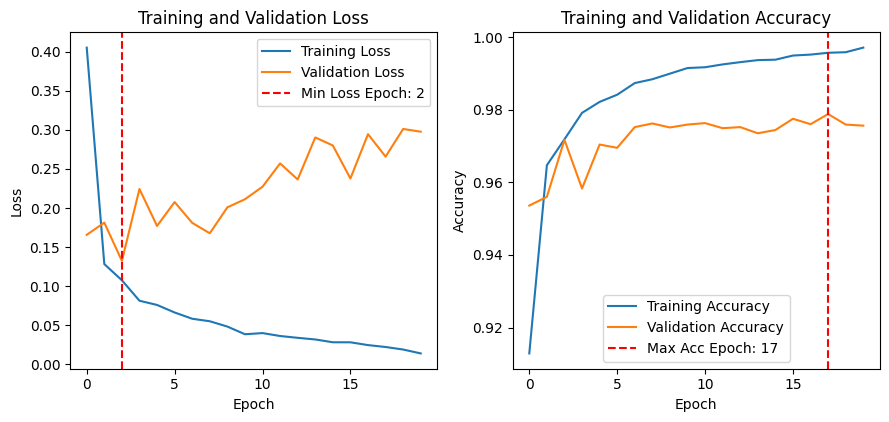

In [ ]:
plot_training_history(model_eleven_history)

Increasing the learning rate has resulted in quite a significant increase in loss and a slight increase in accuracy. Due to this, the learning rate will be kept at the rmsprop default of 0.001.

## Model Twelve - L2 Regularisation
L2 regularisation is a regularisation technique used in neural networks to prevent overfitting, encouraging the model to generalise better to unseen data. To start, we can explore this with a regularisation of 0.01.

In [ ]:
from tensorflow.keras import regularizers

# model twelve:
model_twelve = tf.keras.models.Sequential()
model_twelve.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(28 * 28,)))
model_twelve.add(tf.keras.layers.Dense(10, activation='softmax'))


model_twelve.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model_twelve_history = model_twelve.fit(partial_image_train, partial_label_train, epochs = 20, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/20
391/391 [==============================] - 5s 12ms/step - loss: 1.1404 - accuracy: 0.8764 - val_loss: 0.5695 - val_accuracy: 0.8678
Epoch 2/20
391/391 [==============================] - 6s 16ms/step - loss: 0.4775 - accuracy: 0.9107 - val_loss: 0.4856 - val_accuracy: 0.9068
Epoch 3/20
391/391 [==============================] - 5s 14ms/step - loss: 0.4302 - accuracy: 0.9221 - val_loss: 0.4144 - val_accuracy: 0.9255
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.4024 - accuracy: 0.9269 - val_loss: 0.4237 - val_accuracy: 0.9251
Epoch 5/20
391/391 [==============================] - 7s 17ms/step - loss: 0.3788 - accuracy: 0.9325 - val_loss: 0.4239 - val_accuracy: 0.9176
Epoch 6/20
391/391 [==============================] - 4s 11ms/step - loss: 0.3610 - accuracy: 0.9375 - val_loss: 0.3879 - val_accuracy: 0.9272
Epoch 7/20
391/391 [==============================] - 5s 13ms/step - loss: 0.3519 - accuracy: 0.9380 - val_loss: 0.3499 - val_accuracy: 0.9400

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven, model_eight, model_nine, model_ten, model_eleven, model_twelve]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven', 'Model Eight', 'Model Nine', 'Model Ten', 'Model Eleven', 'Model Twelve']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2300 - accuracy: 0.9634


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822
6,Model Eight,0.072769,0.9837
7,Model Nine,0.070567,0.9840
8,Model Ten,0.070123,0.9828
9,Model Eleven,0.279920,0.9766


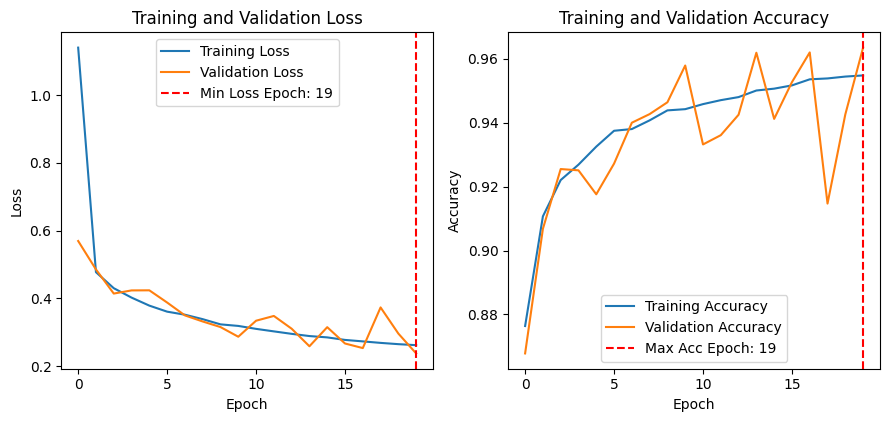

In [ ]:
plot_training_history(model_twelve_history)

Adding L2 regularisation has resulted in an increase in loss and decrease in overall accuracy, meaning in this case it is not improving the model.

This technique will not be used in the final model.

# Results

## Model Overview
- Model one: 2 layers, no validation, 128 neurons, 5 epochs
- Model two: 2 layers, validation, 128 neurons, 5 epochs
- Model three: 2 layers, validation, 128 neurons, 10 epochs
- Model four: 2 layers, validation, 128 neurons, 20 epochs
- Model five: 2 layers, validation, 128 neurons, 40 epochs
- Model six: 3 layers, validation, 128 neurons, 30 epochs
- Model seven: 2 layers, validation, 512 neurons, 30 epochs
- Model eight: 2 layers, validation, 1024 neurons, 30 epochs
- Model nine: 2 layers, validation, 1024 neurons, 20 epochs
- Model ten: 2 layers, validation, 1024 neurons, 20 epochs, dropout = 0.5
- Model eleven: 2 layers, validation, 1024 neurons, 20 epochs, learning rate = 0.01
- Model twelve: 2 layers, validation, 1024 neurons, 20 epochs, L2 regulariser = 0.01



The final model is as follows:
- 2 layers
- Validation
- 1024 neurons
- 20 epochs

In [ ]:
# final model:
final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(1024, activation='relu', input_shape=(28 * 28,)))
final_model.add(tf.keras.layers.Dense(10, activation='softmax'))


final_model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

final_model_history = final_model.fit(partial_image_train, partial_label_train, epochs = 20, batch_size = 128, validation_data = (image_val, label_val))

Epoch 1/20
391/391 [==============================] - 5s 12ms/step - loss: 0.2642 - accuracy: 0.9223 - val_loss: 0.1452 - val_accuracy: 0.9539
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 0.1026 - accuracy: 0.9690 - val_loss: 0.0963 - val_accuracy: 0.9726
Epoch 3/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0660 - accuracy: 0.9800 - val_loss: 0.0800 - val_accuracy: 0.9754
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0456 - accuracy: 0.9866 - val_loss: 0.0956 - val_accuracy: 0.9720
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 0.0731 - val_accuracy: 0.9782
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0225 - accuracy: 0.9935 - val_loss: 0.0750 - val_accuracy: 0.9792
Epoch 7/20
391/391 [==============================] - 5s 12ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.0754 - val_accuracy: 0.9781

Accuracy of final model:

In [ ]:
test_loss, test_accuracy = final_model.evaluate(test_images, test_labels)

print(f"Model accuracy: {test_accuracy}")
print(f"Loss: {test_loss}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0679 - accuracy: 0.9833
Model accuracy: 0.983299970626831
Loss: 0.06785693019628525


Lets compare the final model to the other models:

In [ ]:
models = [model_two, model_three, model_four, model_five, model_six, model_seven, model_eight, model_nine, model_ten, model_eleven, model_twelve, final_model]
model_names = ['Model Two', 'Model Three', 'Model Four', 'Model Five', 'Model Six', 'Model Seven', 'Model Eight', 'Model Nine', 'Model Ten', 'Model Eleven', 'Model Twelve', 'Final Model']

result_df = compare_models(models, model_names, test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0679 - accuracy: 0.9833


,Model,Test Loss,Test Accuracy
0,Model Two,0.095469,0.9717
1,Model Three,0.075939,0.9768
2,Model Four,0.084221,0.9776
3,Model Five,0.105387,0.9786
4,Model Six,0.134735,0.9787
5,Model Seven,0.079498,0.9822
6,Model Eight,0.072769,0.9837
7,Model Nine,0.070567,0.9840
8,Model Ten,0.070123,0.9828
9,Model Eleven,0.279920,0.9766


The final model ended up being model 10 without dropout. Interestingly, even though dropout, learning rate, and L2 regularisation were tested as hyperparameters, they resulted in higher loss and lower accuracy respectively. This is likely due to the model not experiencing overfitting that these specific hyperparameters could have helped reduce.

Here is the final plot of the loss and accuracy for training and validation:

As seen, it does not appear to overfit. The 20 epochs of the final model fit the minimum loss and maximum accuracy observed.

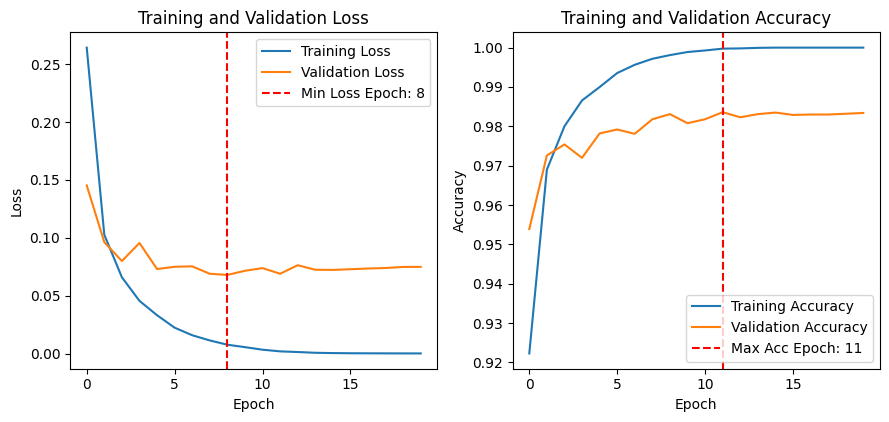

In [ ]:
plot_training_history(final_model_history)

Finally, we can conduct some tests with examples of the test data:

Class:  0 with Probability: 1.000000000000000 (Highest Probability)
Class:  1 with Probability: 0.000000000000000
Class:  2 with Probability: 0.000000000000001
Class:  3 with Probability: 0.000000000000000
Class:  4 with Probability: 0.000000000027003
Class:  5 with Probability: 0.000000000000000
Class:  6 with Probability: 0.000000000004315
Class:  7 with Probability: 0.000000000000000
Class:  8 with Probability: 0.000000000000000
Class:  9 with Probability: 0.000000000000207

Predicted class: 0
Actual class: 0
image: 


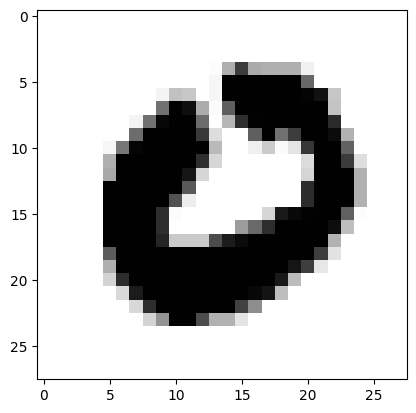

In [ ]:
predict_and_print(final_model, 25, 25)

print('image: ')
plt.imshow(raw_test_images[25], cmap = plt.cm.binary)
plt.show()

Class:  0 with Probability: 0.000000114150666
Class:  1 with Probability: 0.000000005126129
Class:  2 with Probability: 0.000000046425445
Class:  3 with Probability: 0.000000000014455
Class:  4 with Probability: 0.000000001670631
Class:  5 with Probability: 0.000000079456882
Class:  6 with Probability: 0.999999761581421 (Highest Probability)
Class:  7 with Probability: 0.000000000050511
Class:  8 with Probability: 0.000000018528580
Class:  9 with Probability: 0.000000000002583

Predicted class: 6
Actual class: 6
image: 


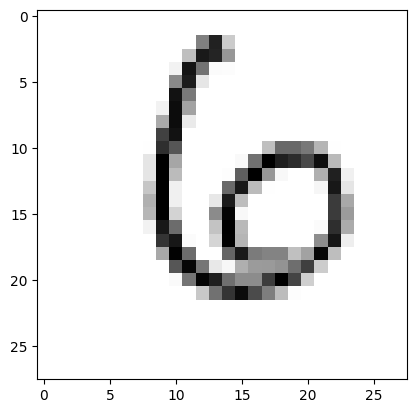

In [ ]:
predict_and_print(final_model, 100, 100)

print('image: ')
plt.imshow(raw_test_images[100], cmap = plt.cm.binary)
plt.show()

As seen, the final model can successfully predict the image class with a high accuracy. The accuracy for this model is 98% overall and the loss is 6.8%.

### Universal Workflow

At the beginning of the report I laid out the universal workflow that I would be following.

I have successfully defined the problem and assembled a dataset, chosen a measure of success, decided evaluation protocol, prepared the data, and developed a model that performs better than the baseline. However, I have not been able to develop a model that overfits the data as I struggled with the initial hyperparameters tuned not resulting in overfitting.

I still followed the workflow despite this, finishing with regularising the model and tuning hyperparameters based on validation data performance.

# Conclusion

The final model was able to exceed the baseline accuracy of 11%, reaching 98%. Hyperparameters with the most impact on loss and accuracy of the training and validation data were epochs, units/neurons, and layers.

Although the final model was able to reach a high accuracy and relatively low loss, there are hyperparameters that were not explored, such as batch size, different activation functions, and momentum. Given more time, this is something that could be explored.

I also did not test the model with one of my own test images, handwritten by me. Again, this is something I would explore further given more time, as I would be able to further explore how the model performs on unknown data.

## References
Wenger, J. (2023). Artificial Intelligence Course Notebooks, Virtual Learning Environment, Goldsmiths, University of London

Chollet, F. (2021). Deep Learning With Python, Second Edition, Manning

In [ ]:
%%shell
jupyter nbconvert --to html /content/coursework_one_mnist.ipynb

[NbConvertApp] Converting notebook /content/coursework_one_mnist.ipynb to html
[NbConvertApp] Writing 1936965 bytes to /content/coursework_one_mnist.html
